# Path smoothing
Smoothen the path through gradient descent.  
### Make a copy of the original path  
`y_i = x_i`  
### Optimise over two terms  
```
# minimise distance between original points and smooth points
min (x_i - y_i)^2
# minimise distance between consecutive smooth points
min (y_i - y_(i+1))^2
```  
### Combine and weight by parameters alpha and beta
`y_i = y_i + alpha * (x_i - y_i) + beta * (y_(i+1) + y_(i-1) - 2 * y_i)`

In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, clear_output
from copy import deepcopy

In [2]:
# plot each iteration of path smoothing
def plot_smooth(path):
    x1 = [row[0] for row in path]
    y1 = [row[1] for row in path]
    x2 = deepcopy(x1)
    y2 = deepcopy(y1)

    # get all intermediate smoothened paths
    paths = smooth(path, save_intermediate=True)

    # for larger numbers of smoothing steps, plot only every nth step
    if len(paths) > 20:
        include_step = list(map(int, np.floor(np.linspace(0, len(paths), 10))))
        # always include the final path
        if (len(paths) - 1) not in include_step:
            include_step.append((len(paths) - 1))
    else:
        include_step = range(20)

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    plt.close()
    ax.cla()

    ax.plot(x1, y1, '-r')
    ax.plot(x2, y2, '-g')

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title(f"Smoothing step 0")

    display(fig)    
    clear_output(wait = True)
    plt.pause(0.2) 

    for step, smooth_path in enumerate(paths):
        if step not in include_step:
            continue
        ax.cla()
        x2 = [row[0] for row in smooth_path]
        y2 = [row[1] for row in smooth_path]

        ax.plot(x1, y1, '-r')
        ax.plot(x2, y2, '-g')

        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_title(f"Smoothing step {step + 1}")

        display(fig)    
        clear_output(wait = True)
        plt.pause(0.1)

In [26]:
# -----------
# User Instructions
#
# Define a function smooth that takes a path as its input
# (with optional parameters for weight_data, weight_smooth,
# and tolerance) and returns a smooth path. The first and 
# last points should remain unchanged.
#
# Smoothing should be implemented by iteratively updating
# each entry in newpath until some desired level of accuracy
# is reached. The update should be done according to the
# gradient descent equations given in the instructor's note
# below (the equations given in the video are not quite 
# correct).
# -----------

# thank you to EnTerr for posting this on our discussion forum
def printpaths(path,newpath):
    for old,new in zip(path,newpath):
        print('['+ ', '.join('%.3f'%x for x in old) + \
               '] -> ['+ ', '.join('%.3f'%x for x in new) +']')

# Don't modify path inside your function.
path = [[0, 0],
        [0, 1],
        [0, 2],
        [1, 2],
        [2, 2],
        [3, 2],
        [4, 2],
        [4, 3],
        [4, 4]]

def smooth(path, weight_data = 0.5, weight_smooth = 0.1, tolerance = 0.000001,
    iter_max=1000, save_intermediate=False):

    # Make a deep copy of path into newpath
    newpath = deepcopy(path)

    # optionally store all intermediate paths
    if save_intermediate:
        paths = []

    # track how big the change is in each step
    # either stop on convergence (change below tolerance)
    # or after iter_max iterations.
    iter_count = 0
    change = tolerance
    while change >= tolerance:
        change = 0.0
        if iter_count >= iter_max:
            raise(Warning("Convergence not reached within max iterations."))
            return newpath

        # update all points except the startpoint and endpoint
        for i in range(1, (len(path) - 1)):
            for j in range(len(path[i])):
                previous_path_val = newpath[i][j]
                newpath[i][j] += (
                    weight_data * (path[i][j] - newpath[i][j]) +
                    weight_smooth * (newpath[i + 1][j] + newpath[i - 1][j] - 2 * newpath[i][j])
                )
                # total change over all points in the path
                change += abs(newpath[i][j] - previous_path_val)
        # optionally save the new path
        if save_intermediate:
            paths.append(newpath)
        iter_count += 1
    if save_intermediate:
        return paths
    return newpath

printpaths(path,smooth(path))


[0.000, 0.000] -> [0.000, 0.000]
[0.000, 1.000] -> [0.021, 0.979]
[0.000, 2.000] -> [0.149, 1.851]
[1.000, 2.000] -> [1.021, 1.979]
[2.000, 2.000] -> [2.000, 2.000]
[3.000, 2.000] -> [2.979, 2.021]
[4.000, 2.000] -> [3.851, 2.149]
[4.000, 3.000] -> [3.979, 3.021]
[4.000, 4.000] -> [4.000, 4.000]


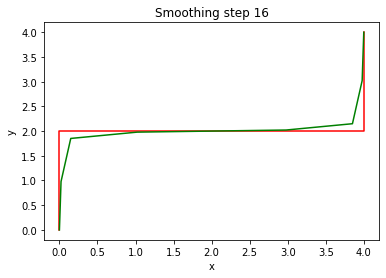

In [28]:
plot_smooth(path)

# PID control

### P control
Staying on track by steering in proportion to the cross track error (CTE): the error between the robot trajectory and the target trajectory.  
This is a **P-controller**: a proportional controller.  

In the P-controller exercise, the target trajectory is the x-axis. Thus, y is the cross track error. Tau is a proportion term. The steering angle alpha is as follows:
```
alpha = -tau * cte
```

### PD control
An oscillating car is unpleasant. Decrease the steering angle in proportion to the decrease of the error in order to dampen the oscillation.  
```
alpha = - tau_p * cte - tau_d * (d/dt cte)
```
Where `d/dt cte = (cte_t - cte_t-1) / delta_t`  
and the proportions are now controlled by two parameters: `tau_p` and `tau_d`.

### PID control
Bias from for instance misaligned wheels can cause a systematic offset from the target trajectory. This can be measured by the integral, or sum, of the cross track errors over time. We add a third term to adjust steering for a sustained bias over time.  
```
alpha = - tau_p * cte - tau_d * (d/dt cte) - tau_i * sum(cte)
```

### Twiddle (coordinate ascent)
How do we find appropriate parameter values for tau_p, tau_d and tau_i?  
* The control function (in these exercises, the `run` function) must return a goodness value: the average cte.  
* Build a parameter vector for the three tau parameters, and initialise it with zeros.  
```
p = [0, 0, 0]
```
* Build a vector with potential changes to the parameters.  
```
dp = [1, 1, 1]
```
* Run the control function with the initial values, and the cte it outputs is the best error so far.  
```
best_err = run(p)
```
* Modify one of the parameters and run the controller again.  
```
for i in range(len(p)):
    p[i] += dp[i]
    err = run(p)
```
* If the newly computed error is smaller than the previous best error, we set the best error to the new one, and we increase this parameter's value change in dp by multiplying it with 1.1.
```
    if err < best_err:
        best_err = err
        dp[i] *= 1.1
```
* If the newly computed error is worse, we subtract the value of dp twice. One time because we added it before, and one time because we want to search in the other direction. Then we run the controller again.
```
    else:
        p[i] -= 2 * dp[i]
        err = run(p)
```
* If both of these are worse than the original best error, we set `p[i]` back to the original value. Then we decrease the parameter change step by multiplying with 0.9.
```
        if err < best_err:
            pass
        else:
            p[i] += dp[i]
            dp[i] *= 0.9
```
* We continue to do this as long as the sum of dp is larger than our tolerance value.
```
while sum(dp) > tolerance:
```

### Robot class
Same as before

In [5]:
class Robot(object):
    def __init__(self, length=20.0):
        """
        Creates robot and initializes location/orientation to 0, 0, 0.
        """
        self.x = 0.0
        self.y = 0.0
        self.orientation = 0.0
        self.length = length
        self.steering_noise = 0.0
        self.distance_noise = 0.0
        self.steering_drift = 0.0

    def set(self, x, y, orientation):
        """
        Sets a robot coordinate.
        """
        self.x = x
        self.y = y
        self.orientation = orientation % (2.0 * np.pi)

    def set_noise(self, steering_noise, distance_noise):
        """
        Sets the noise parameters.
        """
        # makes it possible to change the noise parameters
        # this is often useful in particle filters
        self.steering_noise = steering_noise
        self.distance_noise = distance_noise

    def set_steering_drift(self, drift):
        """
        Sets the systematical steering drift parameter
        """
        self.steering_drift = drift

    def move(self, steering, distance, tolerance=0.001, max_steering_angle=np.pi / 4.0):
        """
        steering = front wheel steering angle, limited by max_steering_angle
        distance = total distance driven, most be non-negative
        """
        if steering > max_steering_angle:
            steering = max_steering_angle
        if steering < -max_steering_angle:
            steering = -max_steering_angle
        if distance < 0.0:
            distance = 0.0

        # apply noise
        steering2 = random.gauss(steering, self.steering_noise)
        distance2 = random.gauss(distance, self.distance_noise)

        # apply steering drift
        steering2 += self.steering_drift

        # Execute motion
        turn = np.tan(steering2) * distance2 / self.length

        if abs(turn) < tolerance:
            # approximate by straight line motion
            self.x += distance2 * np.cos(self.orientation)
            self.y += distance2 * np.sin(self.orientation)
            self.orientation = (self.orientation + turn) % (2.0 * np.pi)
        else:
            # approximate bicycle model for motion
            radius = distance2 / turn
            cx = self.x - (np.sin(self.orientation) * radius)
            cy = self.y + (np.cos(self.orientation) * radius)
            self.orientation = (self.orientation + turn) % (2.0 * np.pi)
            self.x = cx + (np.sin(self.orientation) * radius)
            self.y = cy - (np.cos(self.orientation) * radius)

    def __repr__(self):
        return '[x=%.5f y=%.5f orient=%.5f]' % (self.x, self.y, self.orientation)

## P controller

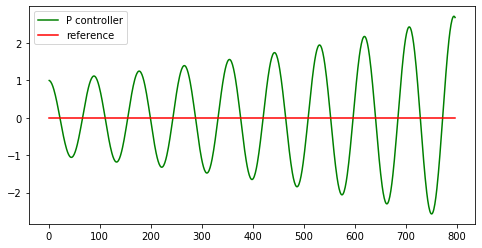

In [6]:
# -----------
# User Instructions
#
# Implement a P controller by running 100 iterations
# of robot motion. The desired trajectory for the 
# robot is the x-axis. The steering angle should be set
# by the parameter tau so that:
#
# steering = -tau * crosstrack_error
#
# You'll only need to modify the `run` function at the bottom.
# ------------

############## ADD / MODIFY CODE BELOW ####################
# ------------------------------------------------------------------------
#
# run - does a single control run
robot = Robot()
robot.set(0.0, 1.0, 0.0)

def run(robot, tau, n=100, speed=1.0):
    x_trajectory = []
    y_trajectory = []
    # TODO: your code here
    for step in range(n):
        cte = robot.y
        steering = -tau * cte
        # perform one step with steering
        robot.move(steering, distance=speed)
        x_trajectory.append(robot.x)
        y_trajectory.append(robot.y)
    return x_trajectory, y_trajectory
    
x_trajectory, y_trajectory = run(robot, 0.1, n=800)
n = len(x_trajectory)

fig, ax1 = plt.subplots(1, 1, figsize=(8, 4))
plt.close()
ax1.plot(x_trajectory, y_trajectory, 'g', label='P controller')
ax1.plot(x_trajectory, np.zeros(n), 'r', label='reference')
ax1.legend()
display(fig)

## PD controller

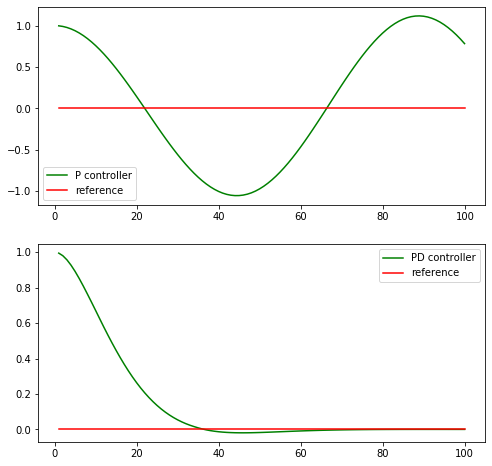

In [7]:
# -----------
# User Instructions
#
# Implement a PD controller by running 100 iterations
# of robot motion. The steering angle should be set
# by the parameter tau_p and tau_d so that:
#
# steering = -tau_p * CTE - tau_d * diff_CTE
# where differential crosstrack error (diff_CTE)
# is given by CTE(t) - CTE(t-1)
#
#
# Only modify code at the bottom! Look for the TODO
# ------------

# previous P controller
def run_p(robot, tau, n=100, speed=1.0):
    x_trajectory = []
    y_trajectory = []
    for i in range(n):
        cte = robot.y
        steer = -tau * cte
        robot.move(steer, speed)
        x_trajectory.append(robot.x)
        y_trajectory.append(robot.y)
    return x_trajectory, y_trajectory


def run(robot, tau_p, tau_d, n=100, speed=1.0):
    x_trajectory = []
    y_trajectory = []
    # TODO: your code here
    cte = robot.y
    for t in range(n):
        # note that this will use the previous value of cte, thus cte at t - 1
        diff_cte = robot.y - cte
        cte = robot.y
        steer = - tau_p * cte - tau_d * diff_cte
        robot.move(steer, speed)
        x_trajectory.append(robot.x)
        y_trajectory.append(robot.y)
    return x_trajectory, y_trajectory

# PD control
robot = Robot()
robot.set(0.0, 1.0, 0.0)
x_trajectory, y_trajectory = run(robot, 0.2, 3.0, n=100)
n = len(x_trajectory)

# P control
robot = Robot()
robot.set(0, 1, 0)
p_x_trajectory, p_y_trajectory = run_p(robot, 0.1, n=100)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
plt.close()
ax1.cla()
ax2.cla()
ax1.plot(p_x_trajectory, p_y_trajectory, 'g', label='P controller')
ax1.plot(p_x_trajectory, np.zeros(n), 'r', label='reference')
ax1.legend()
ax2.plot(x_trajectory, y_trajectory, 'g', label='PD controller')
ax2.plot(x_trajectory, np.zeros(n), 'r', label='reference')
ax2.legend()
display(fig)

## Systematic bias
Misaligned wheels add a systematic offset.

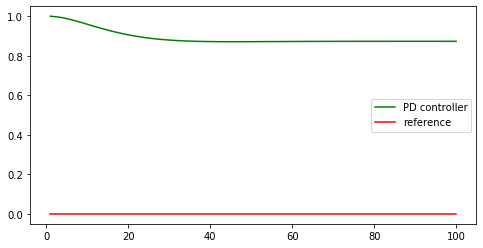

In [8]:
# PD control
robot = Robot()
robot.set(0.0, 1.0, 0.0)
# add a steering drift
robot.set_steering_drift(10.0 / 180 * np.pi)
x_trajectory, y_trajectory = run(robot, 0.2, 3.0, n=100)
n = len(x_trajectory)

fig, ax1 = plt.subplots(1, 1, figsize=(8, 4))
plt.close()
ax1.cla()
ax1.plot(x_trajectory, y_trajectory, 'g', label='PD controller')
ax1.plot(x_trajectory, np.zeros(n), 'r', label='reference')
ax1.legend()
display(fig)

## PID control

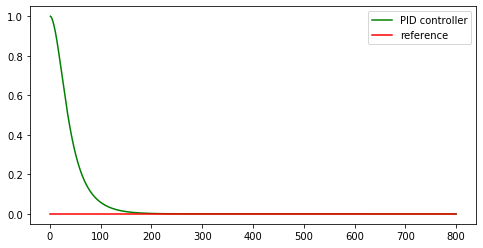

In [25]:
# -----------
# User Instructions
#
# Implement a P controller by running 100 iterations
# of robot motion. The steering angle should be set
# by the parameter tau so that:
#
# steering = -tau_p * CTE - tau_d * diff_CTE - tau_i * int_CTE
#
# where the integrated crosstrack error (int_CTE) is
# the sum of all the previous crosstrack errors.
# This term works to cancel out steering drift.
#
# Only modify code at the bottom! Look for the TODO.
# ------------


def run(robot, tau_p, tau_d, tau_i, n=100, speed=1.0):
    x_trajectory = []
    y_trajectory = []
    # TODO: your code here
    cte = robot.y
    sum_cte = 0.0
    for t in range(n):
        # note that this will use the previous value of cte, thus cte at t - 1
        diff_cte = robot.y - cte
        cte = robot.y
        # add all cte until now
        sum_cte += cte
        steer = - tau_p * cte - tau_d * diff_cte - tau_i * sum_cte
        robot.move(steer, speed)
        x_trajectory.append(robot.x)
        y_trajectory.append(robot.y)
    return x_trajectory, y_trajectory

robot = Robot()
robot.set(0, 1, 0)
# add a steering drift
robot.set_steering_drift(10.0 / 180 * np.pi)
x_trajectory, y_trajectory = run(robot, 0.2, 3.0, 0.004, n=800)
n = len(x_trajectory)

fig, ax1 = plt.subplots(1, 1, figsize=(8, 4))
plt.close()
ax1.cla()
ax1.plot(x_trajectory, y_trajectory, 'g', label='PID controller')
ax1.plot(x_trajectory, np.zeros(n), 'r', label='reference')
ax1.legend()
display(fig)

## Twiddle (coordinate ascent)

In [10]:
# ----------------
# User Instructions
#
# Implement twiddle as shown in the previous two videos.
# Your accumulated error should be very small!
#
# You don't have to use the exact values as shown in the video
# play around with different values! This quiz isn't graded just see
# how low of an error you can get.
#
# Try to get your error below 1.0e-10 with as few iterations
# as possible (too many iterations will cause a timeout).
#
# No cheating!
# ------------

def make_robot():
    """
    Resets the robot back to the initial position and drift.
    You'll want to call this after you call `run`.
    """
    robot = Robot()
    robot.set(0.0, 1.0, 0.0)
    robot.set_steering_drift(10.0 / 180.0 * np.pi)
    return robot


# NOTE: We use params instead of tau_p, tau_d, tau_i
def run(robot, params, n=100, speed=1.0):
    x_trajectory = []
    y_trajectory = []
    err = 0
    prev_cte = robot.y
    int_cte = 0
    for i in range(2 * n):
        cte = robot.y
        diff_cte = cte - prev_cte
        int_cte += cte
        prev_cte = cte
        steer = -params[0] * cte - params[1] * diff_cte - params[2] * int_cte
        robot.move(steer, speed)
        x_trajectory.append(robot.x)
        y_trajectory.append(robot.y)
        if i >= n:
            err += cte ** 2
    return x_trajectory, y_trajectory, err / n


# Make this tolerance bigger if you are timing out!
def twiddle(tol=0.2): 
    # Don't forget to call `make_robot` before every call of `run`!
    p = [0.0, 0.0, 0.0]
    dp = [1.0, 1.0, 1.0]
    robot = make_robot()
    x_trajectory, y_trajectory, best_err = run(robot, p)

    # continue until parameter changes are below tolerance
    while sum(dp) > tol:
        for i in range(len(p)):
            p[i] += dp[i]
            robot = make_robot()
            x_trajectory, y_trajectory, err = run(robot, p)

            # if better, increase the parameter change
            if err < best_err:
                best_err = err
                dp[i] *= 1.1
            # if not, update param in the opposite direction
            else:
                # subtract once because we added it before,
                # and once to search in the other direction
                p[i] -= 2 * dp[i]
                robot = make_robot()
                x_trajectory, y_trajectory, err = run(robot, p)

                # if better, update best error and continue to next parameter
                if err < best_err:
                    best_err = err
                # if not, set param back to original value and decrease change size
                else:
                    p[i] += dp[i]
                    dp[i] *= 0.9
    
    return p, best_err

Final twiddle error = 3.0938990903289917e-20
[2.1908668761107237, 8.680269090832017, 0.22731022123912964]


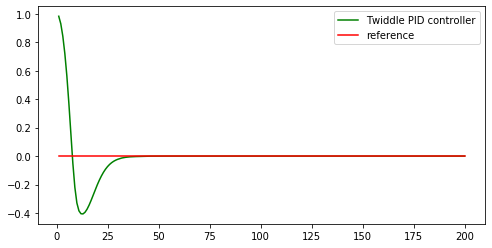

In [11]:
params, err = twiddle(0.00001)
print("Final twiddle error = {}".format(err))
print(params)
robot = make_robot()
x_trajectory, y_trajectory, err = run(robot, params)
n = len(x_trajectory)

fig, ax1 = plt.subplots(1, 1, figsize=(8, 4))
plt.close()
ax1.cla()
ax1.plot(x_trajectory, y_trajectory, 'g', label='Twiddle PID controller')
ax1.plot(x_trajectory, np.zeros(n), 'r', label='reference')
ax1.legend()
display(fig)